In [1]:
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'

## What was done in file_reduction.ipynb:
Every touch events was tied to a second. Then, each row of the dataframe would represent how many times one user touched their phone in one second. 
Now, spikes in the data (defined as the statistical outliers) have been treated and moved to the median of the distribution. 

# Cleaning Data: reasonable results and time-interpretable grouping.
In order to get in second 40 touches per second you need to use all ten fingers on the screen, four times, or alternatively just your thumbs 20 times. In one second. Which is just impossible. Consider this: 
- the fastest finger tapping rate was set by Japanese musician Kaoru Watanabe in 2014. He achieved a rate of 13.36 taps per second.
- Prabhshish Singh (at 13) accurately typed letters from A to Z on a mobile phone in just 3 seconds and 44 milliseconds, as confirmed on August 29, 2022, making it about 7.5 touches each second. 

Not all users here must be world-record breakers, so for now statistical outliers will be treated as data spikes derived from device malfunction or improper handling of the screen.

We need to consider the **extreme touches**. If a value is an outlier it needs to be subsituted with the median. The median is a much more defensible measure because it has much less impact on the statistics than choosing any value, i.e. of the third quartile of the touch distribution. 

In [2]:
from scipy import stats
from tqdm import tqdm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [9]:
by_second_unclean = pd.read_csv("Processed Data/touch_sensor_unclean.csv") 
by_second_unclean = by_second_unclean.drop('Unnamed: 0', axis='columns')
print(f"N of observations: {by_second_unclean.shape[0]:,}")
by_second_unclean.head(3)

N of observations: 19,859,174


,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6
1,1,2020-11-22,2020-11-22 00:00:03,1
2,1,2020-11-22,2020-11-22 00:00:06,2


A brief, general look at statistical outliers:

At least one outlier belongs to: 128 out of 201 of the users
Outliers are 355,932 out of 19,859,174 = 1.79%
touches
1      4266857
2      4127960
3      2299172
4      1728830
5      1200586
        ...   
960          1
966          1
983          1
985          1
998          1
Name: count, Length: 565, dtype: int64


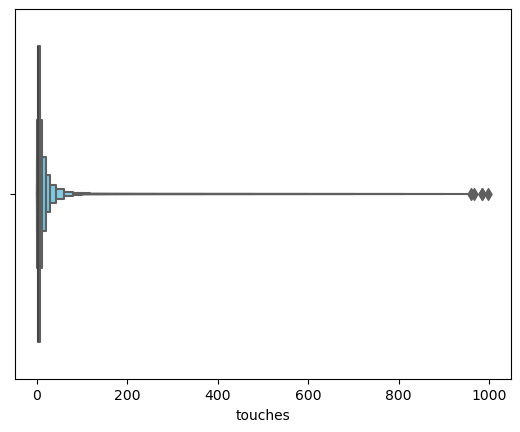

In [10]:
z = np.abs(stats.zscore(by_second_unclean['touches']))
threshold = 3  #this is the typical chosen score for outliers
outliers = by_second_unclean[z > threshold]
#print("User IDs with outlier observations:\n", np.sort(outliers.userid.unique()))
print(f"At least one outlier belongs to: {outliers.userid.unique().shape[0]:,} out of {by_second_unclean.userid.unique().shape[0]:,} of the users")    #should be 1.79%
print(color.BOLD + f"Outliers are {outliers.shape[0]:,} out of {by_second_unclean.shape[0]:,} = {str(round(outliers.shape[0]/ by_second_unclean.shape[0]*100, 2))}%" + color.END)
print(by_second_unclean.touches.value_counts().sort_index())
sns.boxenplot(data = by_second_unclean, x=by_second_unclean.touches, color='#4CC9F0')
plt.show()

Now, treating those statistical outliers. **Run the following cell only once.**

In [11]:
# Replacing the 1.79% outliers for the data that has seconds as units with their median
median, std = by_second_unclean['touches'].median(), by_second_unclean['touches'].std()
outliers = (by_second_unclean['touches'] - median).abs() > std

by_second = by_second_unclean    
by_second.touches[outliers] = np.nan
by_second['touches'].fillna(median, inplace=True)   # by_second is the cleaner version

by_second.head(3)

/tmp/ipykernel_35598/1054526867.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  by_second.touches[outliers] = np.nan


,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6.0
1,1,2020-11-22,2020-11-22 00:00:03,1.0
2,1,2020-11-22,2020-11-22 00:00:06,2.0


In [13]:
by_second.to_csv('Processed Data/by_second_clean.csv')

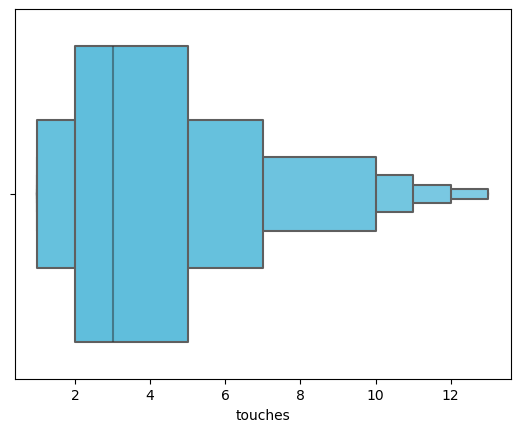

In [12]:
sns.boxenplot(data = by_second, x=by_second.touches, color='#4CC9F0', 
              k_depth='trustworthy', trust_alpha=0.05)
plt.show()

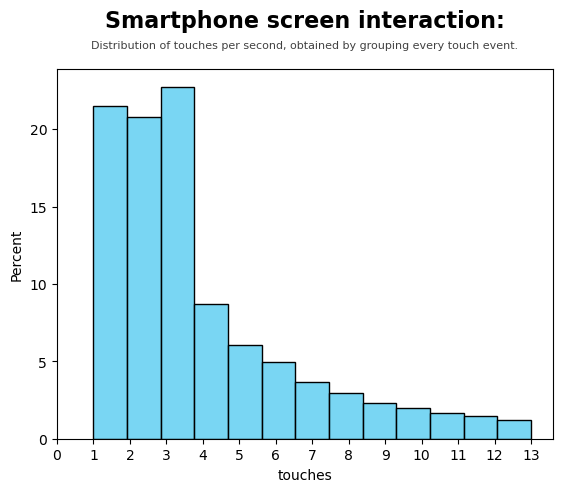

In [15]:
g = sns.histplot(data = by_second, x=by_second.touches, stat='percent', color='#4CC9F0', bins=13)
g.text(x=0.5, y=1.1, s='Smartphone screen interaction per second:', fontsize=16, weight='bold', ha='center', va='bottom', transform=g.transAxes)
g.text(x=0.5, y=1.05, s='Distribution of touches per second, obtained by grouping every touch event.', fontsize=8, alpha=0.75, ha='center', va='bottom', transform=g.transAxes)
g.set_xticks(range(14))
g.set_xticklabels([0,1,2,3,4,5,6,7,8,9,10,11,12,13])
plt.show()

## Operations in the next sections:
- Cleaning data from lacking / dropout users
- Applying the concept of circadian time on days and hours

Very obviously, only the users that gave enough days to be useful the experiment should be considered. Below I plotted separately the distribution of events (seconds in which there is at least one touch) over the days in which data was collected. 

Ideally, the observation should the 15 days of maximum observation, **starting from when most users logged** and **ending when they start to drop out massively**. Personally, I choose the two week period starting from 2020/11/12 and ending 2020/11/27, which is also the same time around the WeNet project sent a notification each half-hour of the day to users - in the time diary data of the project. It will help with more accuracy for activities and locations that the user was in while using the smartphone.
### Distribution: count of events (grouped by second) registered between the start and end of observation period
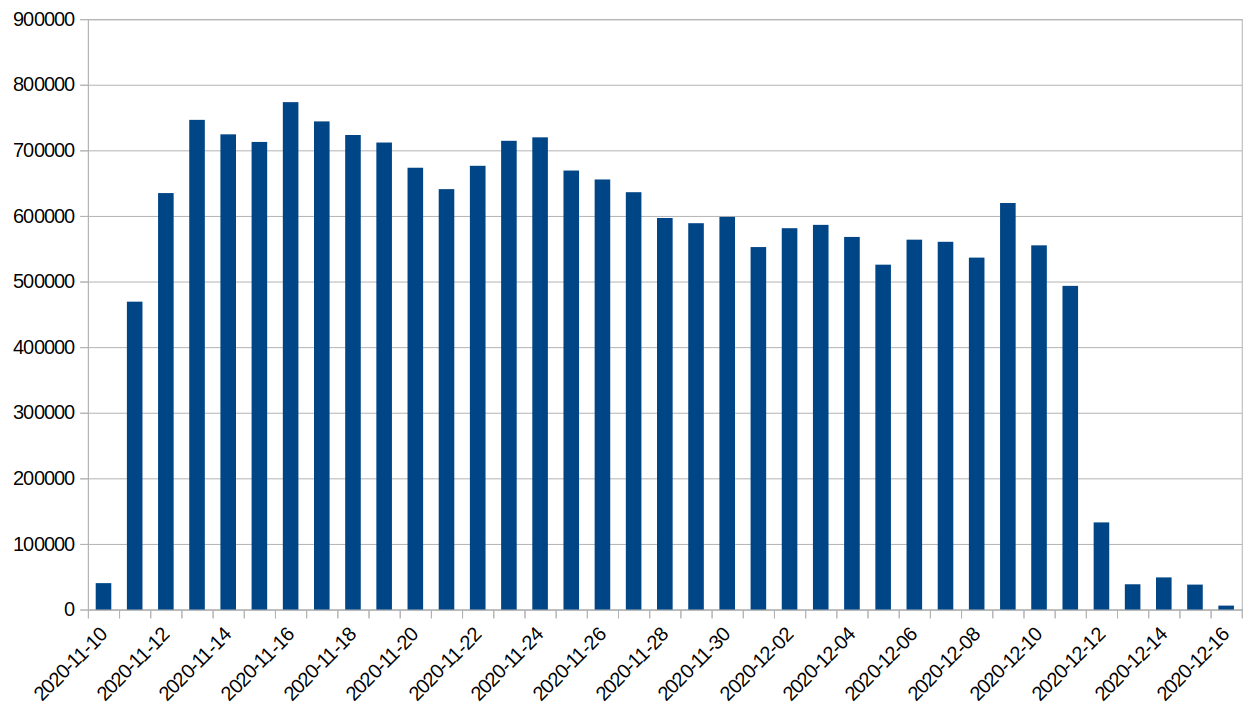

What also needs to be done is to mark each row as belonging to a specific circadian day - differently from clock time, but not independently. 
The logic is exemplified as follows: when one user is scrolling their phone from 23:59:00 until 00:20:10 and then went to sleep and did not wake up until the morning after, and we want to group per day (for visualization and analysis purposes) the times they were scrolling, we should count everything that happened from 00:00:00 to 00:20:10 and consider it part of the previous day. This logic should seamlessy apply to the many students that don't stop their day before 24:00:00.  

According to prof. Bison and the WeNet team, an ideal breakpoint for counting circadian day activities is between 04:30:00 and 05:00:00, because at that time everyone usually has finished their day and the next will start in a few minutes or hours. 

In [3]:
%time
by_second = pd.read_csv('Processed Data/by_second_clean.csv')
timestamp, day = pd.to_datetime(by_second.timestamp, yearfirst=True), pd.to_datetime(by_second.day, yearfirst=True)
by_second.timestamp, by_second.day = timestamp, day
by_second = by_second.drop('Unnamed: 0',axis='columns')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs


In [4]:
by_second.head()

,userid,day,timestamp,touches
0,1,2020-11-22,2020-11-22 00:00:00,6.0
1,1,2020-11-22,2020-11-22 00:00:03,1.0
2,1,2020-11-22,2020-11-22 00:00:06,2.0
3,1,2020-11-22,2020-11-22 00:00:53,2.0
4,1,2020-11-22,2020-11-22 00:00:54,1.0


In [5]:
IDs=by_second.userid.unique()
IDs.sort()

#data structure:
'''
{id: [2020-11-12, 2020-11,13, 2020-11-14,...]}   #for every ID, there is a list of days in which there is at least one observation from them. 
'''
user_activity = dict()
for ID in tqdm(IDs):
    id_act = by_second[by_second.userid == ID]
    # adding to the dictionary
    user_activity[f'{ID}'] = pd.Series(id_act.day.unique()).sort_values().reset_index()

print('N:',len(user_activity.keys()))
print("Done!")

100%|█████████████████████████████████████████| 201/201 [00:05<00:00, 36.76it/s]

N: 201
Done!


Now, I need to know who went through the whole period and who didn't. This means:
- counting the days the user sent 

In [6]:
def gantt_data_org(k, v):
    #gantt data is named after the Gantt chart, although it's not present here
    
    #S is the Series of days; it's best if it's a consecutive 14 days (regardless of when they start)
    
    tot = 0
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
        start, end = v[0], v[-1]
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            if difference >= 2:    # if there is more than one day of difference it means that there was one 
                                   # day in the data with no observations
                consecutive = False
                break
            else:
                consecutive = True
                
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['userid', 'start', 'finish', 'tot', 'cons'])

#example of output:
gantt_data_org(1, ["2020-11-12", "2020-11-13", "2020-11-14", "2020-11-15", "2020-11-16", 
                   "2020-11-17",   "2020-11-18", "2020-11-19", "2020-11-25"])


,userid,start,finish,tot,cons
0,1,2020-11-12,2020-11-25,13,False


In [8]:
gantt_data = pd.DataFrame(columns=["userid", "start", "finish", "tot", "cons"])
for ID, days in user_activity.items():
    res = gantt_data_org(ID, days[0].tolist())
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)

In [9]:
gantt_data.tot.value_counts().sort_index()

tot
0     10
1      2
2      2
3      4
4      1
5      3
6      2
7      2
8      1
9      4
10     1
11     3
12     1
13     3
14     4
15     3
17     2
18     3
19     2
20     7
22     1
23     5
24     1
26     3
27     1
28     5
29    13
30    49
31    34
32    14
33     5
34     4
35     5
36     1
Name: count, dtype: int64

In [10]:
less_than_14 = sum(gantt_data.tot.value_counts().sort_index()[0:15])
more_than_14 = sum(gantt_data.tot.value_counts().sort_index()[15:])
total = less_than_14 + more_than_14
print(f"Users with 14 days or less of recorded activity:\n{color.BOLD}{less_than_14}{color.END}")
print(f"15 days or more of recorded activity: \n{color.BOLD}{more_than_14}{color.END}")
print()
print(f"Total: \n{color.BOLD}{total}{color.END}")

Users with 14 days or less of recorded activity:
43
15 days or more of recorded activity: 
158

Total: 
201


There are 43 users who are absolutely not eligible for my analysis and are considered dropped out because they didn't even register 15 days, but 135 users who did well. Now that the general distribution has been seen, I will apply the same filter (people who did 15 days and people who did 14 or less) but regarding the specific time period of 12th November to the 27th of the same month.

As we can see in the figure below, most people dropped out around the 30th day or so because they complied with a continuation of the experiment, which was facultative for extending the data. Unfortunately, since in another dataset containing the time diary data, in the 12-27 period of November there is supposedly an answer at least every 30 minutes, and after there is an answer at least every 60 minutes (the notifications from the app recording the data were fired at different rates from one period to the other), making it less accurate.

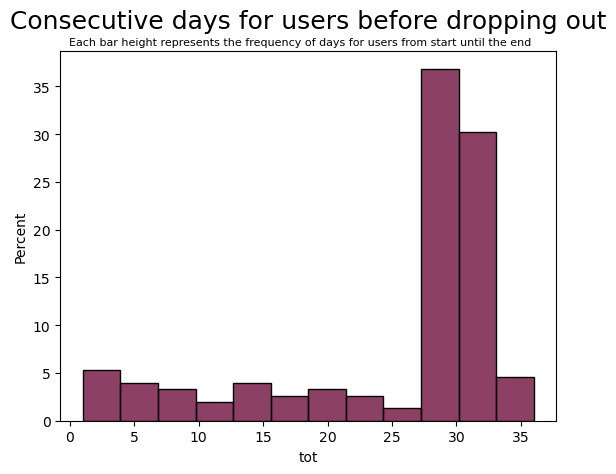

In [11]:
g = gantt_data[gantt_data.cons==True]

sns.histplot(data=g, x=g.tot, stat="percent", color="#660033")
plt.suptitle("Each bar height represents the frequency of days for users from start until the end", y=0.91, ha='center', fontsize=8)
plt.title("Consecutive days for users before dropping out", y=1.04,fontsize=18)
plt.show()

In [12]:
# Filtering for period of interest
user_activity = dict()
for ID in tqdm(IDs):
    id_act = by_second[by_second.userid == ID]
    id_act = id_act[id_act.day.dt.month == 11]
    id_act = id_act[id_act.day.dt.day <= 27]
    id_act = id_act[id_act.day.dt.day >= 12]
    # adding to the dictionary
    user_activity[f'{ID}'] = pd.Series(id_act.day.unique()).sort_values().reset_index()
print("N:",len(user_activity.keys()))
print("New Filtering done!")

gantt_data = pd.DataFrame(columns=["userid", "start", "finish", "tot", "cons"])
for ID, days in user_activity.items():
    res = gantt_data_org(ID, days[0].tolist())
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)
gantt_data.tot.value_counts().sort_index()

100%|█████████████████████████████████████████| 201/201 [00:13<00:00, 14.87it/s]


N: 201
New Filtering done!


tot
0      11
1       3
2       4
3       3
4       3
5       3
7       3
8       1
9       2
10      2
11      2
12      4
13      9
14      4
15    147
Name: count, dtype: int64

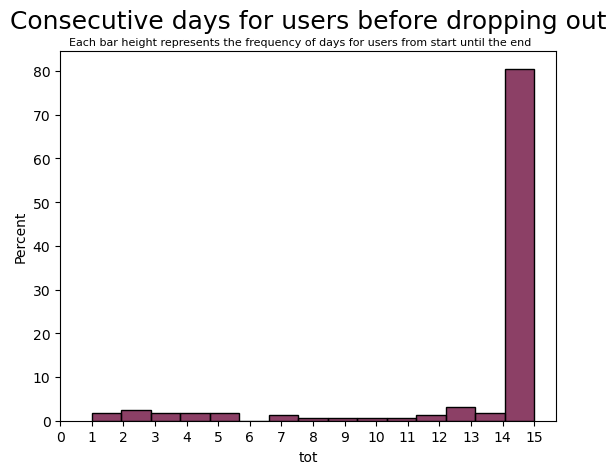

In [13]:
g = gantt_data[gantt_data.cons==True]
p = sns.histplot(data=g, x=g.tot, stat="percent", color="#660033", bins=15)
p.set_xticks(range(16)) 
plt.suptitle("Each bar height represents the frequency of days for users from start until the end", y=0.91, ha='center', fontsize=8)
plt.title("Consecutive days for users before dropping out", y=1.04,fontsize=18)
plt.show()

In [17]:
dropouts = gantt_data[gantt_data.tot < 14].userid
print("Expected drop in user id count: from", gantt_data.shape[0], "to", gantt_data.shape[0] - len(dropouts))

df = by_second[~ by_second['userid'].isin(dropouts.astype(int))]
print(f'Rows of the whole dataset after selection: \n{color.BOLD}{by_second.shape[0]:,}{color.END}', )
print(f'Rows of the whole dataset after selection: \n{color.BOLD}{df.shape[0]:,}{color.END}', )
print("N° of users:", len(df.userid.unique()))

Expected drop in user id count: from 201 to 151
Rows of the whole dataset after selection: 
19,859,174
Rows of the whole dataset after selection: 
18,515,601
N users: 151


Now, denoting what time a row belongs to using human day measures:

In [29]:
df['circaday'] = df[(df['max_speed'] > 1) & (df['shield'] < 8)]

/tmp/ipykernel_24546/1448367285.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['circaday'] = df['timestamp'].dt.hour


In [22]:
df['circaday'] = df[(df['circaday'] == )]

,userid,day,timestamp,touches,circaday
0,1,2020-11-22,2020-11-22 00:00:00,6.0,0
1,1,2020-11-22,2020-11-22 00:00:03,1.0,0
2,1,2020-11-22,2020-11-22 00:00:06,2.0,0
3,1,2020-11-22,2020-11-22 00:00:53,2.0,0
4,1,2020-11-22,2020-11-22 00:00:54,1.0,0
...,...,...,...,...,...
19859169,208,2020-11-24,2020-11-24 23:06:12,2.0,23
19859170,208,2020-11-24,2020-11-24 23:06:13,1.0,23
19859171,208,2020-11-24,2020-11-24 23:06:14,2.0,23
19859172,208,2020-11-24,2020-11-24 23:06:18,1.0,23
